# Citation Network Analysis for Intersex Health Knowledge Base

## Leveraging CrossRef publication API to measure the impact of articles on the collective literature in a research field.

DEPENDENT: Networkx = 2.6.3

In [40]:
# to ensure we are in the correct env in UAB CHEAHA research cluster
!conda env list

# conda environments:
#
mlops                    /home/jmdelay/.conda/envs/mlops
network               *  /home/jmdelay/.conda/envs/network
base                     /share/apps/rc/software/Anaconda3/2021.11



In [1]:
# necessary libraries + others we may need later
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import json
from semanticscholar import SemanticScholar
import sys
import habanero
import crossref_commons.retrieval
from pybliometrics.scopus import *


Ingest the .cvs from Covidence review site

In [18]:
screen = pd.read_csv('articles.csv')
screen = screen.reset_index()

For each article, search CrossRef for references; create edges in network from article to reference article using DOI.

Note: We needed citations to denote main->reference because PageRank measures influence mostly by in-degree.

In [ ]:
## WE CAN IMPORT AN EARLIER VERSION FOR TESTING ##

#g_in = nx.read_gml('netTest.gml')
#nx.info(g_in)

In [19]:
G = nx.DiGraph()
for index, paper in screen.iterrows():
    doi_from = paper['DOI']
    try:
        citations = crossref_commons.retrieval.get_publication_as_json(doi_from)
        is_valid =True
    except (TypeError, ValueError) as e: # when there is no DOI / cannot access DOI
        is_valid = False
        continue
    if (is_valid == True) and ('reference' in citations.keys()): # paper's reference info available
        for ref in citations['reference']:
            try:
                doi_to = ref['DOI']
                G.add_edge(doi_from,doi_to)
            except KeyError: # reference DOI not available
                continue


In [20]:
nx.info(G)

'DiGraph with 1240 nodes and 1536 edges'

Get list of articles in network, go back into CrossRef and mine info on each article.

In [72]:
ranks = nx.pagerank(G)
ranks = pd.DataFrame.from_dict(ranks,orient='index', columns=['PageRank'])
ranks = ranks.sort_values('PageRank')
for paper in ranks.index:
    try:
        info = crossref_commons.retrieval.get_publication_as_json(paper)
        authors = []
        for auth in info['author']:
            if 'family' in auth.keys():
                authors.append(auth['family'])
        ranks.loc[paper, 'author'] = ','.join(authors)
        
        if type(info['title']) == 'list':
            ranks.loc[paper, 'title'] = info['title'][0]
        else:
            ranks.loc[paper, 'title'] = info['title']
            
        if 'published' in info.keys():
            ranks.loc[paper, 'year'] = info['published']['date-parts'][0][0]
        else:
            ranks.loc[paper, 'year'] = 'missing'
            
    except (ValueError, KeyError) as e:
        ranks.loc[paper, 'author'] = 'error'
        ranks.loc[paper, 'title'] = 'error'
        continue

In [86]:
nx.write_gml(G,'netTest.gml')

In [81]:
ranks

,PageRank,author,title,year
10.1016/S0022-5347(05)66131-9,0.000765,"AKMAN,LIU,LI,BASKIN",[PENILE ANATOMY UNDER THE PUBIC ARCH: RECONSTR...,2001.0
10.1016/j.sempedsurg.2019.150845,0.000765,"Chawla,Rutter,Green,Weidler",[Care of the adolescent patient with congenita...,2019.0
10.1016/j.jpag.2019.08.011,0.000765,"Dabrowski,Johnson,Patel,Hsu,Davis,Goetsch,Habi...",[Turner Syndrome with Y Chromosome: Spontaneou...,2020.0
10.4158/EP-2019-0599,0.000765,"Ganesh,Abadin,Fogelfeld",[Adrenal Vein Sampling Without Discontinuation...,2020.0
10.1089/10926410050167396,0.000765,"Lakshmanan,Peters",[Laparoscopy in the Management of Intersex Ano...,2000.0
...,...,...,...,...
10.1016/S0022-5347(05)68986-0,0.001167,"ALIZAI,THOMAS,LILFORD,BATCHELOR,JOHNSON",[FEMINIZING GENITOPLASTY FOR CONGENITAL ADRENA...,1999.0
10.1016/0002-9378(76)90160-5,0.001224,"Manuel,Katayama,Jones",[The age of occurrence of gonadal tumors in in...,1976.0
10.1016/0022-3468(69)90183-3,0.001225,"Hardy Hendren,Crawford",[Adrenogenital syndrome: The anatomy of the an...,1969.0
10.1111/j.1464-410X.1973.tb12128.x,0.001235,"SPENCE,ALLEN",[Genital Reconstruction in the Female with the...,1973.0


Good to see that the missing data are from unimportant articles.

In [80]:
ranks[ranks['author'].str.contains('error')]

,PageRank,author,title,year
10.1210/jc.84.10.3455,0.000776,error,error,NaN
10.1023/A:1022492106974,0.000779,error,error,NaN
10.1098/rstb.1970.0052,0.000779,error,error,NaN
10.1097/AOG.0000000000002452,0.000780,error,error,NaN
10.1097/AOG.0000000000002458,0.000782,error,error,NaN
10.1016/S0022-5347(01)69789-1,0.000784,error,error,NaN
10.1159/000065490,0.000784,error,error,NaN
10.1097/00019509-199904000-00015,0.000790,error,error,NaN
10.1002/bdrc.21145,0.000791,error,error,NaN
10.1023/A:1016272209463,0.000795,error,error,NaN


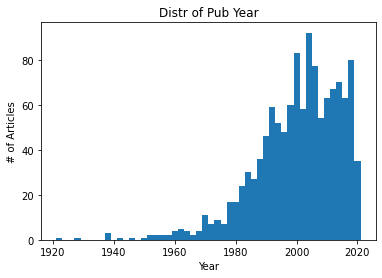

In [84]:
plt.hist(ranks['year'],bins=50)
plt.title("Distr of Pub Year")
plt.xlabel("Year")
plt.ylabel("# of Articles")
plt.show()

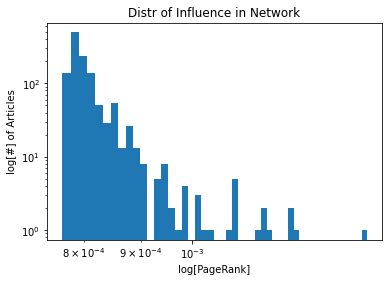

In [87]:
plt.hist(ranks['PageRank'],bins=50)
plt.yscale('log')
plt.xscale('log')
plt.title("Distr of Influence in Network")
plt.xlabel("log[PageRank]")
plt.ylabel("log[# of Articles]")
plt.show()

Distances between any two papers

In [ ]:
distances = nx.floyd_warshall_numpy(G)

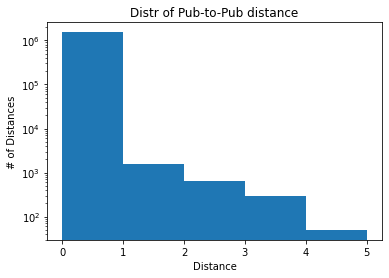

In [90]:
distances[np.isinf(distances)] =0
plt.hist(distances.flatten('F'), bins=[0,1,2,3,4,5])
plt.yscale('log')
plt.title("Distr of Pub-to-Pub distance")
plt.xlabel("Distance")
plt.ylabel("# of Distances")
plt.show()